In [ ]:
#@title Import
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import PowerTransformer
from scipy.stats import t
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math
import seaborn as sns
drive.mount('/content/gdrive')

In [ ]:
#@title Reading the data
df = pd.read_csv("/content/gdrive/My Drive/Thesis-data/data-LDA-other_without_other_imbalanced.csv",low_memory=False)

In [ ]:
#@title applying power transformer
data = df.copy()
for c in df.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    data[c] =  pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [ ]:
#@title assigning a random cluster number to each activity
i=0
z=[]
while i < len(data):
    z.append(random.randrange(0, 14, 1))
    i+=1
data['z']=z

In [ ]:
dt = data.copy()

In [ ]:
#@title Probability calculation function (normal distribution with gamma priors)
def P_normal(x,variable,scale1,data):

  ## hyperparameters
  e0 = 10**4
  t0 = 10**4
  k0 = 0.01
  mo = 0
  
  ####
  nz = len(data)
  sz = sum(data[variable])
  Sz = sum(data[variable]**2)

  ### t-distribution parameters
  v = 2*e0 + nz
  m = (sz + k0 * mo)/(nz + k0)
  sigma2 = (t0 + (nz*Sz - sz**2)/(2*nz) + k0*((sz-nz*mo)**2)/(2*nz*(k0+nz)) )/(e0 + 0.5*nz)
  # print(f'sigma2 is : {sigma2} and mean is :{m}')
  pdf = t.pdf(x,v,m,scale1*sigma2)
  return pdf

In [ ]:
#@title Calculating the estimated distribution parameters function
def distribution_parameter(variable,data,zi):

  ## hyperparameters
  e0 = 10**2
  t0 = 10**2
  k0 = 0.01
  mo = 0
  
  ####
  nz = len(data[data['z']==zi])
  sz = sum(data[data['z']==zi][variable])
  Sz = sum(data[data['z']==zi][variable]**2)

  ### t-distribution parameters
  v = 2*e0 + nz
  m = (sz + k0 * mo)/(nz + k0)
  sigma2 = (t0 + (nz*Sz - sz**2)/(2*nz) + k0*((sz-nz*mo)**2)/(2*nz*(k0+nz)) )/(e0 + 0.5*nz)

  ## Normal distribution parameter ##
  miu = (k0 + sz)/(k0 + nz)
  percision = 1/sigma2

  return miu,percision

In [ ]:
#@title calculating the mentioned probability for an activity (function)
def probabiliy(x,zi,data):
        zi = int(zi)
        P1 = float(P_normal(x['time d'],'time d',1,data[data['z']==zi])) * float(P_normal(x['duration'],'duration',1,data[data['z']==zi])) * float(P_normal(x['frequency'],'frequency',1,data[data['z']==zi]))
        P2 = float(P_normal(x['commercial'],'commercial',1.2,data[data['z']==zi])) * float(P_normal(x['education'],'education',1.2,data[data['z']==zi])) * float(P_normal(x['hospital'],'hospital',1.2,data[data['z']==zi])) * float(P_normal(x['recreational'],'recreational',1.2,data[data['z']==zi])) 
               
        return P1 * P2

In [ ]:
#@ calculating the probability with differnet activity cluster assigned
def P_all_Z(indx):
  l1=[]
  l2=[]
  for i in range(14):
    l1.append(i)
    l2.append(probabiliy(data.iloc[indx],i,data))
  data.at[indx,'z'] = l1[np.argmax(l2)]
  df.at[indx,'z'] = l1[np.argmax(l2)]

In [ ]:
#@title Liklihood function
## Liklihood ##
def likelihood(data,k):
  x2 = 0
  for i in tqdm(range(len(data))):
    x1 = 0
    for j in range(k):
      x1 += probabiliy(data.iloc[i],j,data)

    x2 = x2 + np.log(x1)

  return x2

## Perplexity ##
def perplexity(data,k):

  return np.exp(-1*likelihood(data,k)/len(data))

In [ ]:
#likelihood(data,14)

In [ ]:
#@title Gibbs sampling loop for distribution estimation
for j in range(4):
  print(f'iteration number is : {j}')
  len1 = len(data[data['z']==1])
  len2 = len(data[data['z']==2])
  len3 = len(data[data['z']==3])
  len4 = len(data[data['z']==4])
  len5 = len(data[data['z']==5])
  len6 = len(data[data['z']==6])
  len7 = len(data[data['z']==7])
  len8 = len(data[data['z']==8])
  len9 = len(data[data['z']==9])
  print(f'z1: {len1}, z2: {len2}, z3: {len3}, z4: {len4}, z5: {len5}, z6: {len6}, z7: {len7}, z8: {len8}, z9: {len9}')
  
  for i in tqdm(range(len(data))):

    P_all_Z(i)


iteration number is : 0
z1: 1320, z2: 3756, z3: 7719, z4: 4801, z5: 1908, z6: 5423, z7: 1536, z8: 7883, z9: 1232


100%|██████████| 48065/48065 [2:52:37<00:00,  4.64it/s]


In [ ]:
len1 = len(data[data['z']==1])
len2 = len(data[data['z']==2])
len3 = len(data[data['z']==3])
len4 = len(data[data['z']==4])
len5 = len(data[data['z']==5])
len6 = len(data[data['z']==6])
len7 = len(data[data['z']==7])
len8 = len(data[data['z']==8])
len9 = len(data[data['z']==9])
print(f'z1: {len1}, z2: {len2}, z3: {len3}, z4: {len4}, z5: {len5}, z6: {len6}, z7: {len7}, z8: {len8}, z9: {len9}')

z1: 1362, z2: 3526, z3: 7542, z4: 5277, z5: 1956, z6: 5471, z7: 1633, z8: 7701, z9: 1260


In [ ]:
data.to_csv("/content/gdrive/My Drive/Thesis-data/10000_LDA_iteration(frequency1).csv",index=False)

# **Result Visualization:**

In [ ]:
df['z'] = data['z']

In [ ]:
df['weekend']= [0]* len(df)
df.loc[df['Day_name']=='Friday','weekend']=1
df.loc[df['Day_name']=='Thursday','weekend']=1

<function matplotlib.pyplot.show(*args, **kw)>

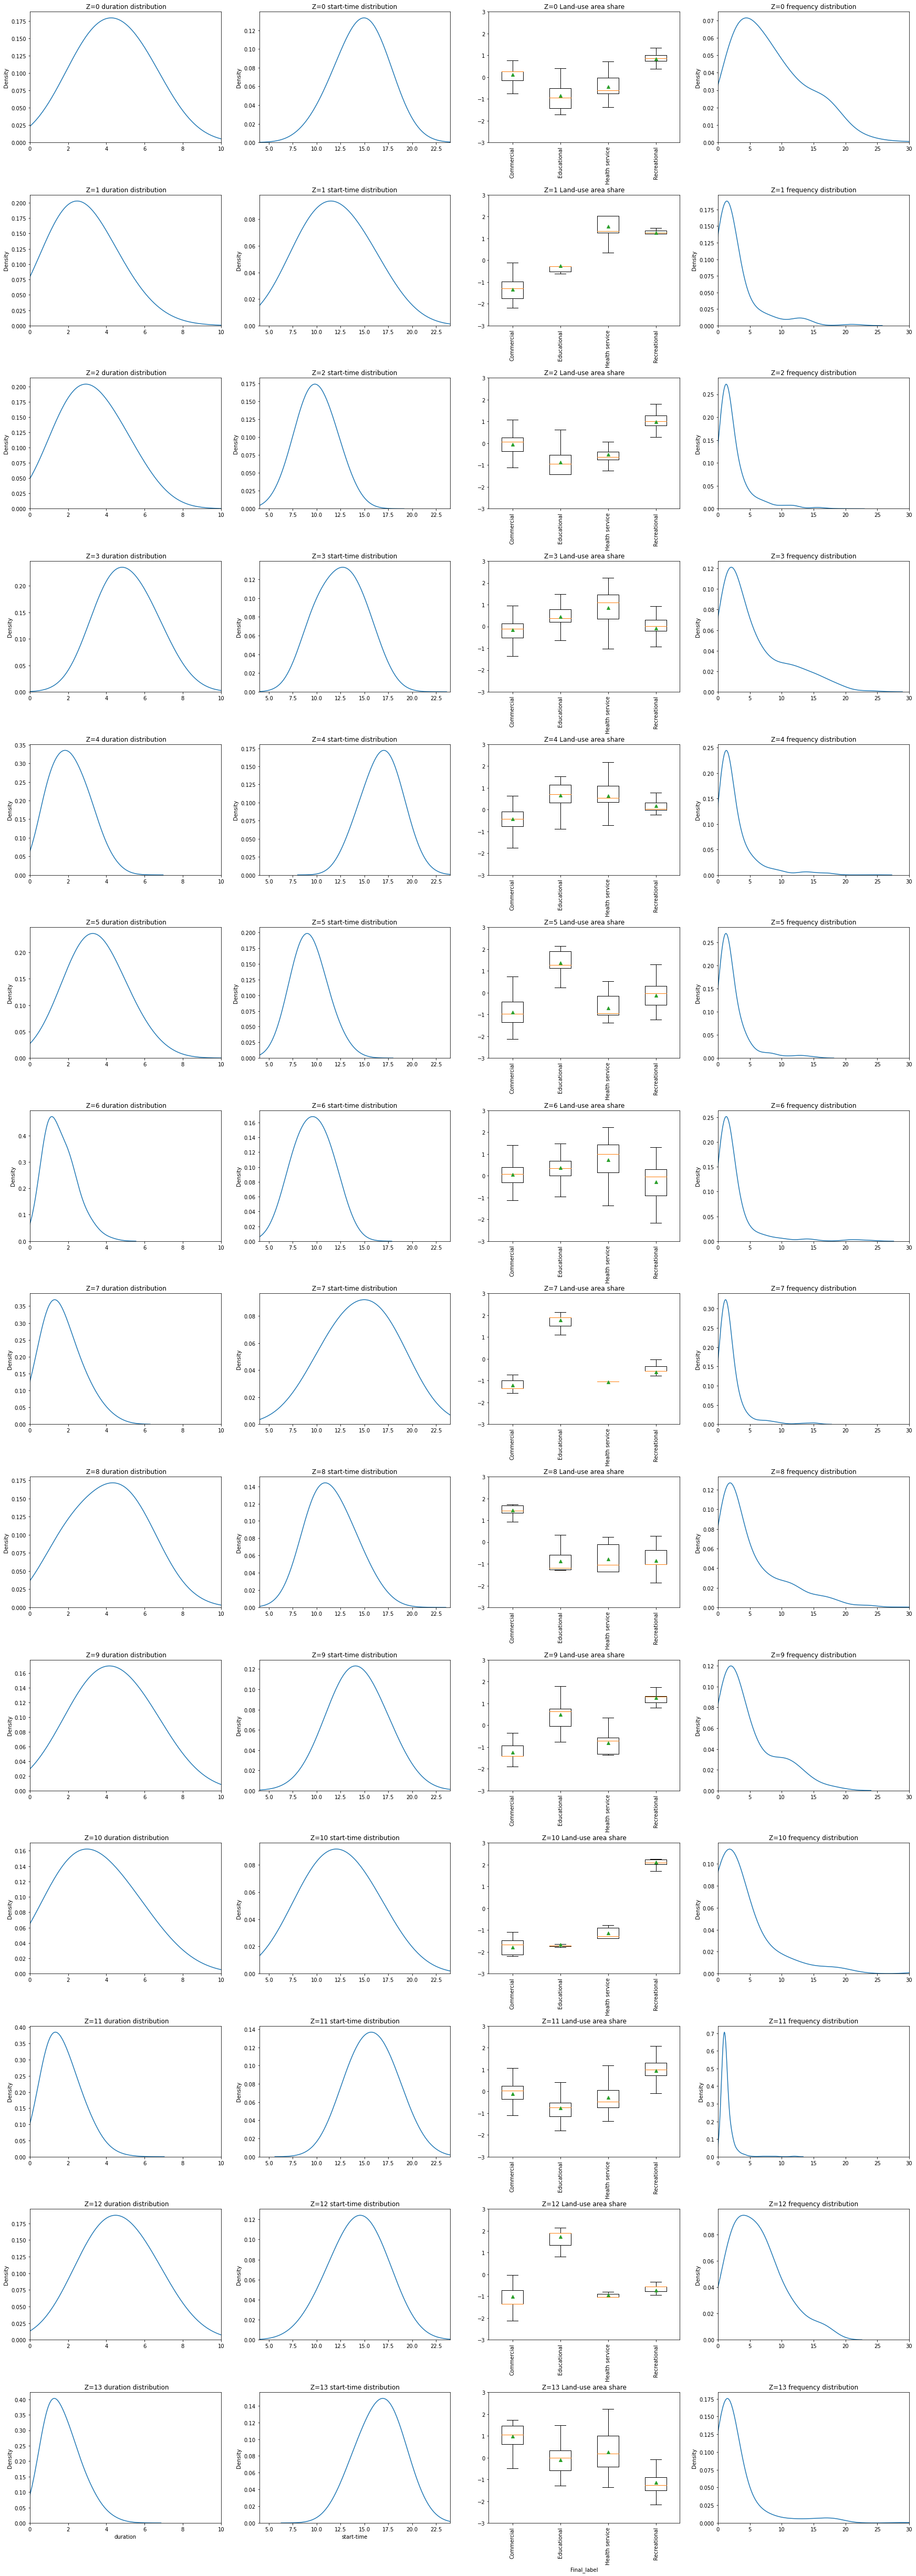

In [ ]:
dataT10 = df.copy()
j=14
fig, axs = plt.subplots(j, 4)
for i in range(j):
  a1 = list(dataT10[dataT10['z']==i]['duration'])
  sns.kdeplot(a1, bw_adjust=4, ax=axs[i,0])
  axs[i,0].set_title(' Z=%d duration distribution'%i)
  axs[i,0].set_xlim(0, 10)

  a1 = list(dataT10[dataT10['z']==i]['time d'])
  sns.kdeplot(a1, bw_adjust=4, ax=axs[i,1])
  axs[i,1].set_title('Z=%d start-time distribution'%i)
  axs[i,1].set_xlim(4, 24)

  data_i = data[data['z']==i]
  d = [data_i['commercial'],data_i['education'],data_i['hospital'],data_i['recreational']]
  axs[i,2].boxplot(d, showfliers=False, showmeans=True)
  axs[i,2].set_xticklabels(['Commercial','Educational','Health service','Recreational'], rotation=90)
  axs[i,2].set_ylim(-3,+3)
  axs[i,2].set_title('Z=%d Land-use area share'%i)


  a1 = list(dataT10[dataT10['z']==i]['frequency'])
  if math.isclose(np.var(a1), 0) == True:
    axs[i,3].hist(a1, density=False)
  else:
    sns.kdeplot(a1, bw_adjust=2, ax=axs[i,3])
  axs[i,3].set_title('Z=%d frequency distribution'%i)
  axs[i,3].set_xlim(0,30)

  plt.subplots_adjust(bottom=0.4, right=4, top=17, hspace=0.4)
  
axs[j-1,0].set(xlabel='duration')
axs[j-1,1].set(xlabel='start-time')
axs[j-1,3].set(xlabel='frequency')
# plt.savefig('/content/gdrive/My Drive/Thesis-data/test_multi_14LDA_Other_1t,2f,1.2h,1.2-wSocialServices_boxplot.png',dpi=300, bbox_inches='tight')
plt.show